# 2nd order servo model

![diagram](../doc/diagrams/control-servo.png)


In [37]:
import numpy
import scipy.linalg
import matplotlib.pyplot as plt

#2nd order state space model
#dx = Ax + Bu

#dv   = -1.0/tau*v + amp/tau*u
#dpos = v

tau = 1.9
amp = 3.1

#fill matrices
a = numpy.zeros((2, 2))
b = numpy.zeros((2, 1))

a[0][0] = -1.0/tau
a[0][1] = 0.0
a[1][0] = 1.0
a[1][1] = 0.0

b[0][0] = amp/tau

print(a)
print(b)

[[-0.52631579  0.        ]
 [ 1.          0.        ]]
[[1.63157895]
 [0.        ]]


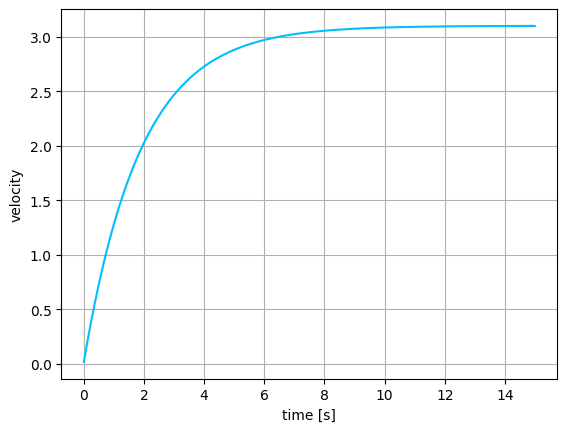

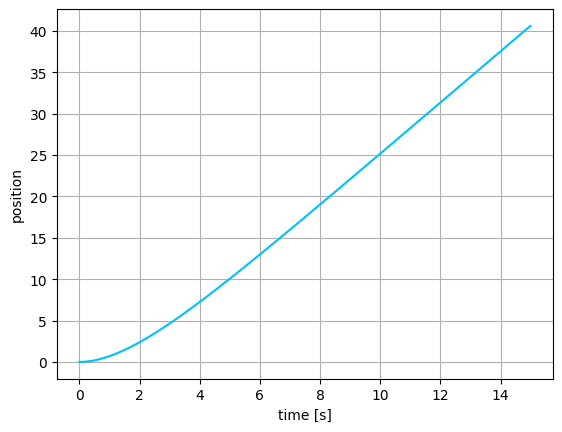

In [38]:
#open loop step response
dt          = 0.01
steps       = 1500
t_result    = numpy.arange(steps)*dt

#initial state
x           = numpy.zeros((2, 1))

#resulted states for ploting
x_result    = numpy.zeros((steps, 2))

for i in range(steps):
    u = numpy.ones((1, 1))

    dx = a@x + b@u
    x  = x + dx*dt

    x_result[i] = x[:, 0]

#plot step response
plt.clf()
plt.ylabel("velocity")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 0], color="deepskyblue")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("position")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 1], color="deepskyblue")
plt.grid()
plt.show()

# LQR controller design

## controller structure 

![diagram](../doc/diagrams/control-lqr.png)


algorithm : 
* given system dynamics : matrices A, B
* given weighting for controlled state, Q matrix
* given weighting for controll signal u, R matrix
* - matrices Q, and R are mostly diagonal

* using Riccati equation compute matrix K
* this matrix stabiles system
* using steady state response with closed loop, compute gain scaling matrix G, which removes steady state error



In [39]:
#controller criterion : weight diagonal matrices
q = numpy.array([ [0.0, 0.0], [0.0, 1.0] ] )
r = numpy.array( [ [0.5] ]) 

#solve LQR controller

#continnuous algebraic Riccati equation
p = scipy.linalg.solve_continuous_are(a, b, q, r)
# compute the LQR gain matrix k
k =  scipy.linalg.inv(r) * (b.T@p) 

#from stready state compute gain matrix
x_steady_state = -numpy.linalg.pinv(a-b@k)@b@k
g = 1.0/numpy.diagonal(x_steady_state)
g = numpy.expand_dims(g, 1)


'''
"custom" riccati solver, numerical integration
r_inv = scipy.linalg.inv(r)
p = numpy.zeros_like(a)
dt = 0.01
for i in range(1000):
    dp = a.T@p + p@a - (p@b)@r_inv@(b.T@p) + q
    p+= dp*dt
'''

#print control matrices
print(k)
print(g)

[[1.03300424 1.41421356]]
[[-5.13216962e+16]
 [ 1.00000000e+00]]


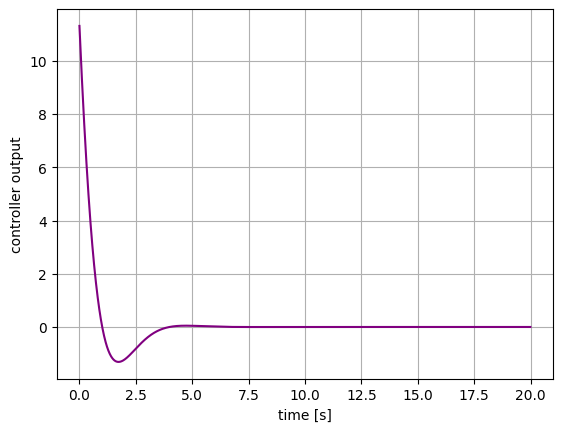

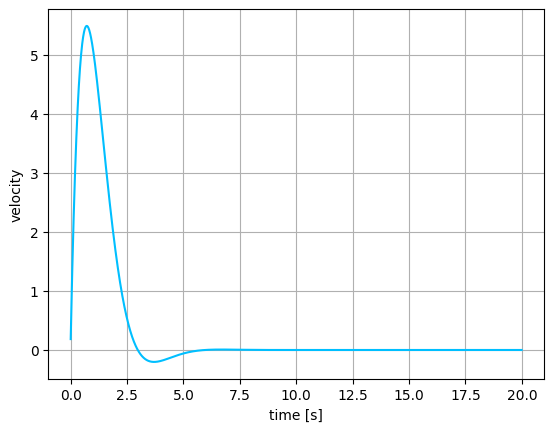

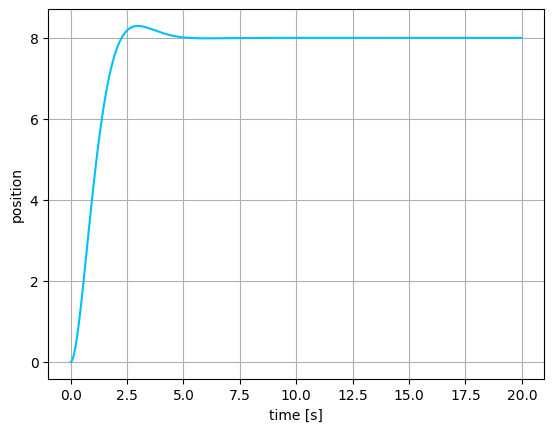

In [40]:
#closed loop step response
dt          = 0.01
steps       = 2000
t_result    = numpy.arange(steps)*dt

#required state, position = 7
xr          = numpy.zeros((2, 1))
xr[1][0]    = 8.0

#initial state
x           = numpy.zeros((2, 1))

#resulted states for ploting
u_result    = numpy.zeros((steps, 1))
x_result    = numpy.zeros((steps, 2))

for i in range(steps):
    u = numpy.ones((1, 1))

    #apply LQR control law
    error = xr*g - x
    u = k@error

    #dynamical system step
    dx = a@x + b@u
    x  = x + dx*dt
    
    u_result[i] = u[0][0]
    x_result[i] = x[:, 0]

#plot response
plt.clf()
plt.ylabel("controller output")
plt.xlabel("time [s]")
plt.plot(t_result, u_result[:, 0], color="purple")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("velocity")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 0], color="deepskyblue")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("position")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 1], color="deepskyblue")
plt.grid()
plt.show()

# adding disturbance

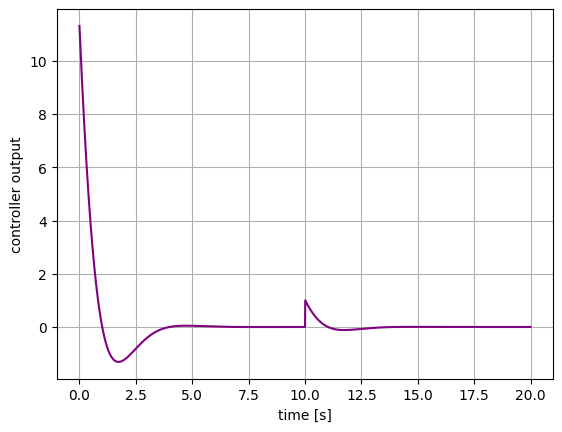

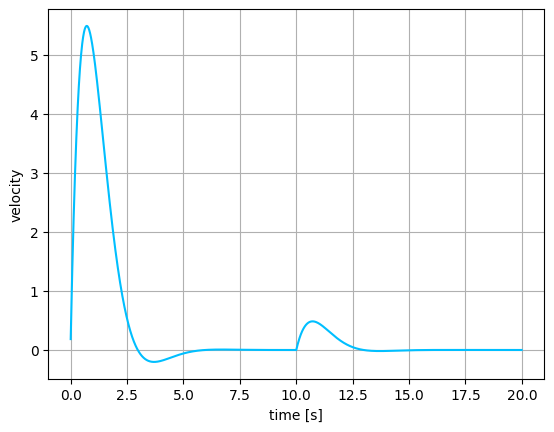

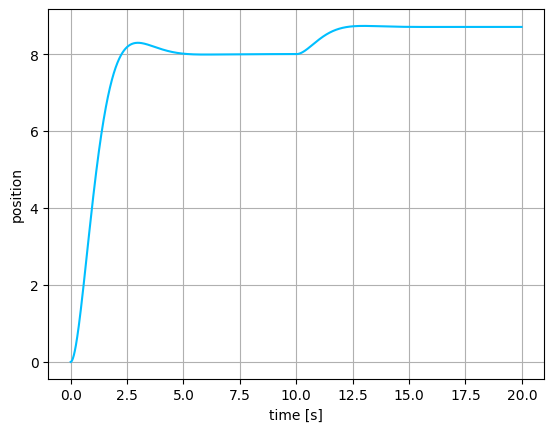

In [41]:
#closed loop step response with disturbance
dt          = 0.01
steps       = 2000
t_result    = numpy.arange(steps)*dt

#required state, position = 7
xr          = numpy.zeros((2, 1))
xr[1][0]    = 8.0

#initial state
x           = numpy.zeros((2, 1))

#resulted states for ploting
u_result    = numpy.zeros((steps, 1))
x_result    = numpy.zeros((steps, 2))

for i in range(steps):
    u = numpy.ones((1, 1))

    #apply LQR control law
    error = xr*g - x
    u = k@error

    # disturbance in middle
    if i > steps//2:
        u+= 1

    #dynamical system step
    dx = a@x + b@u
    x  = x + dx*dt

    
    
    u_result[i] = u[0][0]
    x_result[i] = x[:, 0]

#plot response
plt.clf()
plt.ylabel("controller output")
plt.xlabel("time [s]")
plt.plot(t_result, u_result[:, 0], color="purple")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("velocity")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 0], color="deepskyblue")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("position")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 1], color="deepskyblue")
plt.grid()
plt.show()

# noisy state

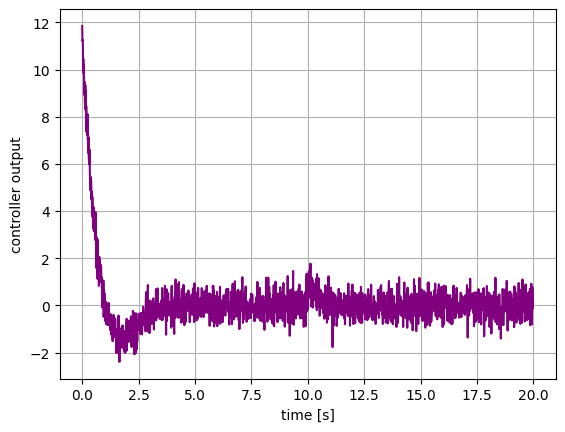

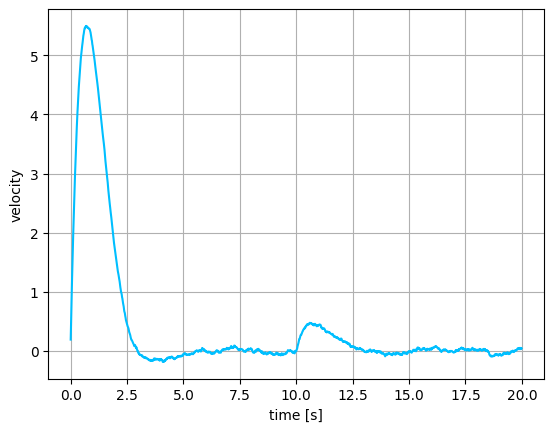

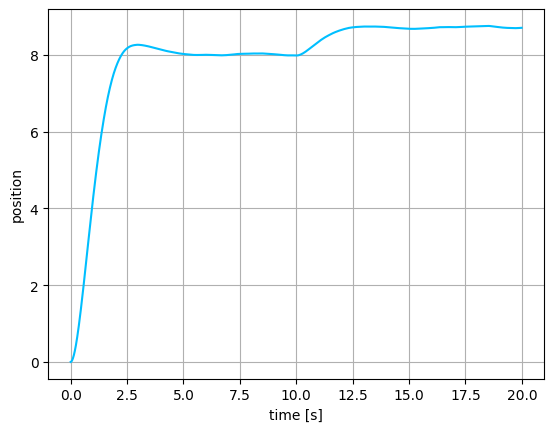

In [42]:
#closed loop step response with noisy state
dt          = 0.01
steps       = 2000
t_result    = numpy.arange(steps)*dt

#required state, position = 7
xr          = numpy.zeros((2, 1))
xr[1][0]    = 8.0

#initial state
x           = numpy.zeros((2, 1))

#resulted states for ploting
u_result    = numpy.zeros((steps, 1))
x_result    = numpy.zeros((steps, 2))

for i in range(steps):
    u = numpy.ones((1, 1))

    # add noise for controller, to simulate sensor noise
    x_noised = x + 0.25*numpy.random.randn(2, 1)

    #apply LQR control law
    error = xr*g - x_noised
    u = k@error

    # disturbance in middle
    if i > steps//2:
        u+= 1


    #dynamical system step
    dx = a@x + b@u
    x  = x + dx*dt
    
    u_result[i] = u[0][0]
    x_result[i] = x[:, 0]

#plot response
plt.clf()
plt.ylabel("controller output")
plt.xlabel("time [s]")
plt.plot(t_result, u_result[:, 0], color="purple")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("velocity")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 0], color="deepskyblue")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("position")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 1], color="deepskyblue")
plt.grid()
plt.show()